In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fit_moffat(x, y, cen_x0, cen_x1, cen_bounds_width=0.3):

    from astropy.modeling import models, fitting
    fit_g = fitting.TRFLSQFitter()

    bounds = {'x_0':(cen_x0-cen_bounds_width/2, cen_x0+cen_bounds_width/2)}
    amp_0 = np.nanmax(y[(x>bounds['x_0'][0]) & (x<bounds['x_0'][1])])
    g1 = models.Moffat1D(amplitude=amp_0, x_0=cen_x0, gamma=0.4, alpha=2, bounds=bounds)

    bounds = {'x_0':(cen_x1-cen_bounds_width/2, cen_x1+cen_bounds_width/2)}
    amp_1 = np.nanmax(y[(x>bounds['x_0'][0]) & (x<bounds['x_0'][1])])
    g2 = models.Moffat1D(amplitude=amp_1, x_0=cen_x1, gamma=0.4, alpha=2, bounds=bounds)
    
    g_init = g1 + g2
    g = fit_g(g_init, x, y)

    g1 = models.Moffat1D(g.amplitude_0, g.x_0_0, g.gamma_0, g.alpha_0)
    g2 = models.Moffat1D(g.amplitude_1, g.x_0_1, g.gamma_1, g.alpha_1)
    return g, g1, g2

In [34]:
wave, *_ = np.loadtxt('../data/Luhman_16_std_J_molecfit_transm.dat').T
wave = wave.reshape((9,3,2048))

i, j = 7, 1
rectified_spec_2d = np.load(f'../data/rectified_spectrum_2d/order_{8-i}_det_{j}.npy')

x = np.linspace(-5,5,len(rectified_spec_2d))-0.13
y = np.nanmedian(rectified_spec_2d, axis=-1)
y -= np.nanmedian(y)

mask = (x>=0) & (x<=4)
y *= -1; rectified_spec_2d *= -1

from scipy.ndimage import generic_filter
#print(rectified_spec_2d.shape)
filtered = generic_filter(rectified_spec_2d, np.nanmedian, size=(1,9), mode='constant', cval=np.nan)

for _ in range(2):
    residuals = rectified_spec_2d - filtered
    
    bpm_mask = np.abs(residuals) > 5*np.nanstd(residuals)
    print(bpm_mask.sum())
    rectified_spec_2d[bpm_mask] = filtered[bpm_mask]

225
741


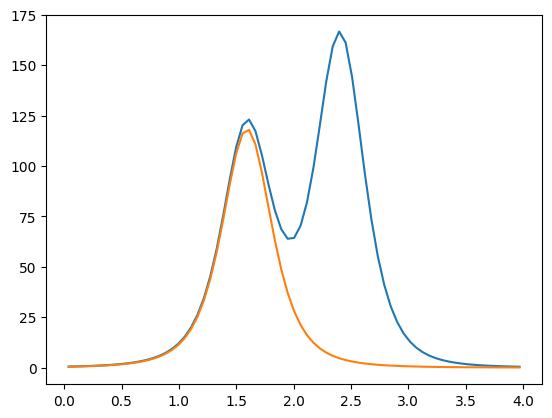

In [64]:
x_A, x_B, ylim

(1.5941243699613936, 2.40661242581273, (1.0941243699613936, 2.90661242581273))

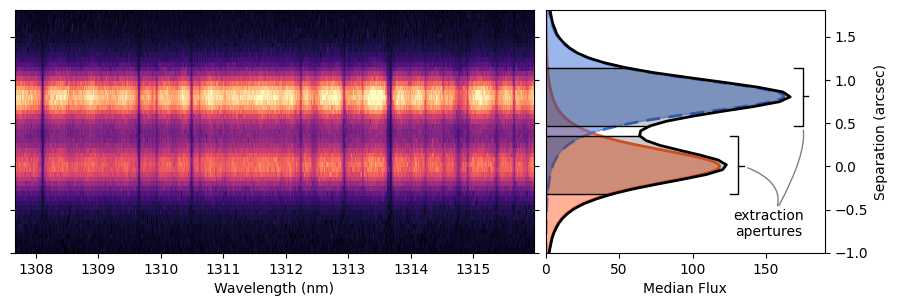

In [321]:
x_A = 1.57
x_B = x_A + 0.81

x_masked, y_masked = x[mask], y[mask]
g, g_A, g_B = fit_moffat(x_masked, y_masked, x_A, x_B)
x_A = g_A.x_0.value
x_B = g_B.x_0.value

color_m_A = '#FF622E'; color_m_B = '#396ED8'

#fig = plt.figure(figsize=(9,3))
fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0, wspace=0.03, width_ratios=[0.65,0.35])
ax = np.array([fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])])

x_fine = np.linspace(x_masked.min(), x_masked.max(), 300)
ax[1].plot(g_A(x_fine), x_fine-x_A, c=color_m_A, lw=2, zorder=-1)
ax[1].plot(g_B(x_fine), x_fine-x_A, c=color_m_B, lw=2, ls=(0,(5,3)), zorder=-1)
ax[1].fill_betweenx(x_fine-x_A, 0, g_A(x_fine), color=color_m_A, alpha=0.5)
ax[1].fill_betweenx(x_fine-x_A, 0, g_B(x_fine), color=color_m_B, alpha=0.5)
ax[1].plot(y_masked, x_masked-x_A, color='k', lw=2)

aper_width = 13*0.056
int_mask_A = (x_masked >= x_A-aper_width/2) & (x_masked <= x_A+aper_width/2)
int_mask_B = (x_masked >= x_B-aper_width/2) & (x_masked <= x_B+aper_width/2)
ax[1].fill_betweenx(x_masked[int_mask_A]-x_A, 0, y_masked[int_mask_A], fc='k', alpha=0.2, ec='none')
ax[1].fill_betweenx(x_masked[int_mask_B]-x_A, 0, y_masked[int_mask_B], fc='k', alpha=0.2, ec='none')

ax[1].plot([0,y_masked[int_mask_A][0]], [x_masked[int_mask_A][0]-x_A]*2, c='k', lw=1, ls='-')
ax[1].plot([0,y_masked[int_mask_A][-1]], [x_masked[int_mask_A][-1]-x_A]*2, c='k', lw=1, ls='-')

ax[1].plot([0,y_masked[int_mask_B][0]], [x_masked[int_mask_B][0]-x_A]*2, c='k', lw=1, ls='-')
ax[1].plot([0,y_masked[int_mask_B][-1]], [x_masked[int_mask_B][-1]-x_A]*2, c='k', lw=1, ls='-')

ax[1].plot(
    0.69-np.array([1,0,0,1])*0.03, x_masked[int_mask_A][[0,0,-1,-1]]-x_A, 
    transform=ax[1].get_yaxis_transform(), c='k', lw=1
)

ax[1].plot(
    0.92-np.array([1,0,0,1])*0.03, x_masked[int_mask_B][[0,0,-1,-1]]-x_A, 
    transform=ax[1].get_yaxis_transform(), c='k', lw=1
)

ylim = (x_A-x_A-1., x_B-x_A+1.)
ax[1].set(xlim=(0,190), ylim=ylim, xlabel='Median Flux', ylabel='Separation (arcsec)')
ax[1].yaxis.tick_right(); ax[1].yaxis.set_label_position('right')

ax[1].axhline(x_A-x_A, xmin=0.69, xmax=0.69+0.02, color='k', lw=1)
ax[1].axhline(x_B-x_A, xmin=0.92, xmax=0.92+0.02, color='k', lw=1)

ax[1].annotate(
    'extraction\n'+'apertures', xy=(0.69+0.02,x_A-x_A), xycoords=ax[1].get_yaxis_transform(),
    xytext=(0.8,0.12), textcoords='axes fraction', 
    ha='center', va='center', fontsize=10, c='w', 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=55,angleB=-20', 
        'shrinkA':0, 'shrinkB':3., 'lw':1, 'color':'k', 'alpha':0.5, 
        }, 

)
ax[1].annotate(
    'extraction\n'+'apertures', xy=(0.92,x_masked[int_mask_B][0]-x_A), xycoords=ax[1].get_yaxis_transform(),
    xytext=(0.8,0.12), textcoords='axes fraction', 
    ha='center', va='center', fontsize=10, c='k', 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=60,angleB=-75', 
        'shrinkA':0, 'shrinkB':3., 'lw':1, 'color':'k', 'alpha':0.5, 
        }, 

)

xlim = (wave[i,j,20:-20].min(axis=-1), wave[i,j,20:-20].max(axis=-1))
ax[0].imshow(
    rectified_spec_2d[mask][:,20:-20], cmap='magma', vmin=-10, vmax=190, 
    aspect='auto', interpolation='none',
    extent=[xlim[0], xlim[1], x_masked[-1]-x_A, x_masked[0]-x_A], 
    )
ax[0].set(xlim=xlim, ylim=ylim, xlabel='Wavelength (nm)', yticklabels=[])
ax[0].yaxis.set_ticks_position('both')

plt.subplots_adjust(left=0.02, bottom=0.16, top=0.97, right=0.92)
plt.savefig(f'./plots/J_band_blend_corr.pdf')

plt.show()

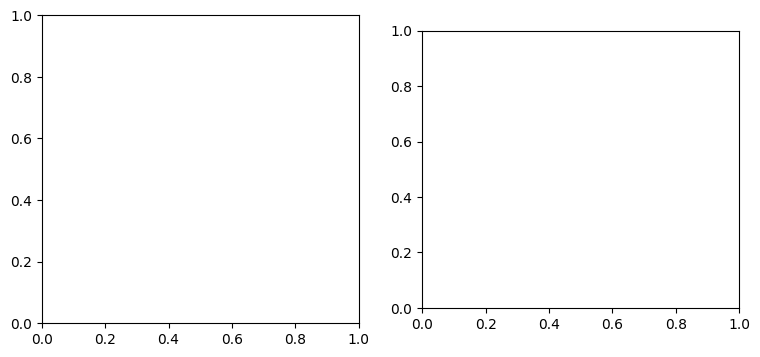

In [9]:
fig = plt.figure(figsize=(9,4))
gs = fig.add_gridspec(nrows=3, ncols=2, hspace=0, wspace=0.2, height_ratios=[0.05,0.9,0.05], width_ratios=)
ax = np.array([
    fig.add_subplot(gs[:,0]),
    fig.add_subplot(gs[1,1]),
])
plt.show()

In [ ]:

aper_width = 13 * 0.056
#aper_width = 11 * 0.056

correction_factors = {'A': np.zeros((9,3,2), dtype=float), 'B': np.zeros((9,3,2), dtype=float)}

for i in range(9):
    for j in list(range(3))[::-1]:
        if i==0 and (j in [1,2]):
            continue

        rect_ord = np.load(f'{path}/rectified_orders/nod_1_{i}_{j}.npy')
        x = np.linspace(-5,5,len(rect_ord))-0.13
        y = np.nanmedian(rect_ord, axis=-1)
        y -= np.nanmedian(y)
        
        fig, ax = plt.subplots(figsize=(10,2))
        for nod_idx, nod in enumerate(['nod_A', 'nod_B']):
            if nod_idx == 0:
                x0 = -1.57
                x1 = x0 - 0.81

                mask = (x>=-4) & (x<=0)
                x_masked, y_masked = x[mask], y[mask]
                g, g_16B, g_16A = fit_moffat(x_masked, y_masked, x0, x1)
            elif nod_idx == 1:
                x0 = 1.57 + 0.81
                x1 = x0 - 0.81

                mask = (x>=0) & (x<=4)
                x_masked, y_masked = x[mask], -y[mask]
                g, g_16B, g_16A = fit_moffat(x_masked, y_masked, x0, x1)

            ax.plot(x_masked, y_masked, c='k', lw=2)

            ax.plot(x_masked, g(x_masked), c='C1', ls='--', lw=2)
            ax.plot(x_masked, g_16B(x_masked), c='C1', ls=':')
            ax.plot(x_masked, g_16A(x_masked), c='C1', ls=':')

            l = g_16B.x_0 - aper_width/2
            h = g_16B.x_0 + aper_width/2
            mask_16B = (x>=l) & (x<=h)

            l = g_16A.x_0 - aper_width/2
            h = g_16A.x_0 + aper_width/2
            mask_16A = (x>=l) & (x<=h)

            ax.fill_between(x[mask_16B], y1=g_16B(x[mask_16B]), y2=0*x[mask_16B], alpha=0.2, color='0.5')
            ax.fill_between(x[mask_16B], y1=g_16A(x[mask_16B]), y2=0*x[mask_16B], alpha=0.6, color='0.5')

            ax.fill_between(x[mask_16A], y1=g_16A(x[mask_16A]), y2=0*x[mask_16A], alpha=0.2, color='0.5')
            ax.fill_between(x[mask_16A], y1=g_16B(x[mask_16A]), y2=0*x[mask_16A], alpha=0.6, color='0.5')


            F_meas_at_B = np.trapz(g(x[mask_16B]), x=x[mask_16B])
            f_B_at_B = np.trapz(g_16B(x[mask_16B]), x=x[mask_16B])/np.trapz(g_16B(x_masked), x=x_masked)
            f_A_at_B = np.trapz(g_16A(x[mask_16B]), x=x[mask_16B])/np.trapz(g_16A(x_masked), x=x_masked)

            F_meas_at_A = np.trapz(g(x[mask_16A]), x=x[mask_16A])
            f_A_at_A = np.trapz(g_16A(x[mask_16A]), x=x[mask_16A])/np.trapz(g_16A(x_masked), x=x_masked)
            f_B_at_A = np.trapz(g_16B(x[mask_16A]), x=x[mask_16A])/np.trapz(g_16B(x_masked), x=x_masked)

            correction_factors['B'][8-i,j,nod_idx] = f_B_at_A/f_B_at_B
            correction_factors['A'][8-i,j,nod_idx] = f_A_at_B/f_A_at_A

            print('"F_tot_B" = F_meas_at_B - {:.3f}*F_meas_at_A'.format(f_A_at_B/f_A_at_A))
            print('"F_tot_A" = F_meas_at_A - {:.3f}*F_meas_at_B'.format(f_B_at_A/f_B_at_B))
            print()

        ax.axvline(0, c='k')
        ax.grid()
        ax.set(xlim=(-3.8,3.8), title=f'i={i}, j={j}')#, ylim=(-3,180))
        plt.show()